In [133]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from matplotlib import cm
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score
import xgboost as xgb
from sklearn.model_selection import KFold
from joblib import dump, load
import scikitplot as skplt
from matplotlib.colors import ListedColormap

### Creating scoring functions for my models

In [134]:
def model_scorer(model, X_train, y_train, X_test, y_test):
    '''prints out model cross validation, test and precision scores together for clarity'''
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(str(model))
    print('cross validated scores-', cv_scores)
    print('mean of cross validated scores-', cv_scores.mean())
    print('test score-', model.score(X_test, y_test))
    model_preds = model.predict(X_test)
    print('precision-', precision_score(y_test, model_preds))

In [135]:
def model_fit_score(model, X_train, y_train, X_test, y_test):
    '''prints out model cross validation, test and precision scores together for clarity'''
    model.fit(X_train, y_train)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(str(model))
    print('cross validated scores-', cv_scores)
    print('mean of cross validated scores-', cv_scores.mean())
    print('test score-', model.score(X_test, y_test))
    model_preds = model.predict(X_test)
    print('precision-', precision_score(y_test, model_preds))

### Loading In data

In [136]:
#loading data
temp_df = pd.read_csv('temp_df.csv')
drop_df = temp_df.copy()

In [138]:
#dropping columns that cannot be used

drop_columns=[
    'emp_title', 'total_rec_prncp', 'out_prncp_inv', 'total_pymnt_inv',
    'funded_amnt_inv', 'last_pymnt_d', 'out_prncp', 'total_pymnt',
    'total_rec_int', 'last_pymnt_amnt', 'title', 'zip_code', 'loan_status',
    'recoveries', 'id', 'member_id', 'next_pymnt_d', 'collection_recovery_fee'
]

for column in drop_columns:
    try:
        drop_df.drop(columns=[column],inplace=True)
    except:
        pass



In [141]:
#finding baseline for models
drop_df.good_or_bad.value_counts(normalize=True)

0    0.664916
1    0.335084
Name: good_or_bad, dtype: float64

# Pre NLP Models

#### Creating train test split and scaling

In [142]:
#creating x and y
Xd = drop_df.copy()
yd = Xd.pop('good_or_bad')

In [143]:
#creating dummy variables for categorical columns
Xd = pd.get_dummies(Xd, drop_first=True)

In [144]:
#creating train and test set
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd,
                                                        yd,
                                                        test_size=0.2,
                                                        random_state=1)

In [145]:
#scaling data
scaler = StandardScaler()
Xd_trains = scaler.fit_transform(Xd_train)
Xd_tests = scaler.transform(Xd_test)

#### Running Models

Running through the models and getting the cv, test, and precision scores

In [10]:
#logistic regression
log_reg_pre_words = load('logistic_regression_no_words.joblib')

In [15]:
model_scorer(log_reg_pre_words, Xd_trains, yd_train, Xd_tests, yd_test)

LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)
cross validated scores- [0.71393873 0.70576712 0.71187902 0.70323642 0.71044589]
mean of cross validated scores- 0.7090534358812751
test score- 0.7157901335172068
precision- 0.6244871163630396


In [16]:
#getting the largest coefficents/ best predictors
log_reg_df = pd.DataFrame({
    'features': Xd.columns,
    'coefs': log_reg_pre_words.coef_[0]
})
log_reg_df['abs'] = log_reg_df.coefs.map(lambda x: abs(x))
print('logistic regression best features')
log_reg_df.sort_values(by='abs', ascending=False).head()

,features,coefs,abs
18,last_credit_pull_d,0.901413,0.901413
17,total_rec_late_fee,0.467166,0.467166
83,term_ 60 months,0.332728,0.332728
113,emp_length_10+ years,-0.301874,0.301874
16,total_acc,-0.281163,0.281163


In [45]:
rf = RandomForestClassifier(n_estimators=800,
                            min_samples_leaf=2,
                            max_depth=None,
                            random_state=1)

In [34]:
model_fit_score(rf, Xd_trains, yd_train, Xd_tests, yd_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
cross validated scores- [0.77364256 0.7579533  0.76915844 0.76976726 0.76961053]
mean of cross validated scores- 0.7680264180415481
test score- 0.7725192753714035
precision- 0.7483640690065437


In [43]:
rf_df = pd.DataFrame({
    'features': Xd.columns,
    'feature_importances': rf.feature_importances_
})
rf_df['abs'] = rf_df.feature_importances.map(lambda x: abs(x))
print('Random forest best features')
rf_df.sort_values(by='abs', ascending=False).head()

Random forest best features


,features,feature_importances,abs
18,last_credit_pull_d,0.164844,0.164844
17,total_rec_late_fee,0.025863,0.025863
23,dti_joint,0.022439,0.022439
2,int_rate,0.022347,0.022347
6,dti,0.022281,0.022281


In [44]:
#ada boost model
ad_model_pre_words = load('ad_model_preword.joblib')

In [46]:
model_scorer(ad_model_pre_words, Xd_trains, yd_train, Xd_tests, yd_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=1000, random_state=1)
cross validated scores- [0.79370054 0.79337094 0.79399781 0.7964893  0.79429512]
mean of cross validated scores- 0.7943707425776628
test score- 0.7910737792264778
precision- 0.7471091000502765


In [47]:
#extra trees
xtra_trees = ExtraTreesClassifier(800, random_state=1)

In [48]:
model_fit_score(xtra_trees, Xd_trains, yd_train, Xd_tests, yd_test)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=800,
                     n_jobs=None, oob_score=False, random_state=1, verbose=0,
                     warm_start=False)
cross validated scores- [0.72663167 0.72371102 0.72089014 0.72549173 0.72525664]
mean of cross validated scores- 0.7243962406629725
test score- 0.7295179590045759
precision- 0.7236363636363636


In [49]:
#Xg boost
#creating training and testing matrices for cross validation
d_train = xgb.DMatrix(data=Xd_trains, label=yd_train)
d_test = xgb.DMatrix(data=Xd_tests, label=yd_test)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [148]:
#creating model
xg_reg_pre_words = xgb.XGBClassifier(objective='reg:logistic',
                                     colsample_bytree=0.3,
                                     learning_rate=0.1,
                                     max_depth=2,
                                     min_child_weight=4,
                                     gamma=0.1,
                                     n_estimators=800)
xg_reg_pre_words.fit(Xd_trains, yd_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [54]:
xg_pre_words_test_score = xg_reg_pre_words.score(Xd_tests, yd_test)

In [56]:
params = {
    'learning_rate': 0.1,
    'max_depth': 2,
    'objective': 'reg:logistic',
    'min_child_weight': 4,
    'gamma': 0.1
}
params['eval_metric'] = 'error'
num_boost_round = 800

In [57]:
cv_results = xgb.cv(params,
                    d_train,
                    num_boost_round=num_boost_round,
                    seed=1,
                    nfold=5,
                    metrics={'error'},
                    early_stopping_rounds=50)

In [58]:
cv_results.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
440,0.196140,0.000454,0.202072,0.002785
441,0.196136,0.000449,0.201962,0.002943
442,0.196120,0.000400,0.202056,0.002920
443,0.196011,0.000453,0.202025,0.002892
444,0.196023,0.000387,0.201947,0.002906


In [59]:
xg_reg_pre_words_feature_importances = pd.DataFrame({
    'columns':
    Xd.columns,
    'importance':
    xg_reg_pre_words.feature_importances_
}).sort_values(by='importance', ascending=False)

In [60]:
xg_reg_pre_words_feature_importances.head()

,columns,importance
18,last_credit_pull_d,0.310706
17,total_rec_late_fee,0.076166
2,int_rate,0.041810
83,term_ 60 months,0.038388
84,grade_D,0.035443


# Post NLP Models

#### Creating train test split using DataFrame post NLP

In [13]:
merged_for_words = pd.read_csv('merged_words.csv')

In [14]:
merged_for_words.to_csv('merged_words.csv')

In [15]:
X = merged_for_words.copy()
y = X.pop('good_or_bad')

In [16]:
X = pd.get_dummies(X, drop_first=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [18]:
y_train.shape

(63809,)

#### Running Models on data with NLP

In [19]:
#scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
#loading in logistic regression model
log_reg_NLP = load('log_reg_postword.joblib')

In [71]:
model_fit_score(log_reg_NLP, X_train, y_train, X_test, y_test)
#Can see not much improvement if any

LogisticRegression(C=0.615848211066026, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000000, multi_class='warn', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)
cross validated scores- [0.71393873 0.708588   0.71383796 0.7073897  0.71068098]
mean of cross validated scores- 0.7108870730599433
test score- 0.7171691844794083
precision- 0.6281341582546401


In [73]:
#loading in random forest model
rf_NLP = load('rand_forest_postwords.joblib')

In [74]:
model_fit_score(rf_NLP, X_train, y_train, X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
cross validated scores- [0.7730941  0.76132268 0.76790472 0.77172635 0.76898362]
mean of cross validated scores- 0.7686062939331699
test score- 0.7718924340249483
precision- 0.7468768590124926


In [76]:
rf_NLP_feature_importances = pd.DataFrame({
    'columns':
    X.columns,
    'importance':
    rf_NLP.feature_importances_
}).sort_values(by='importance', ascending=False)

In [78]:
rf_NLP_feature_importances.head()
#still the same things are important

,columns,importance
20,last_credit_pull_d,0.163541
19,total_rec_late_fee,0.026115
4,int_rate,0.021254
25,dti_joint,0.021151
8,dti,0.020578


In [79]:
#introducing KNN because using it later for stacked model
neigh = KNeighborsClassifier(n_neighbors=140, n_jobs=2)

In [80]:
model_fit_score(neigh, X_train, y_train, X_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=140, p=2,
                     weights='uniform')
cross validated scores- [0.66990519 0.67128977 0.6695659  0.67142074 0.67032364]
mean of cross validated scores- 0.6705010474719119
test score- 0.672161975803924
precision- 0.5523520485584219


In [81]:
rf_entropy_NLP = load('rf_ent_postword.joblib')

In [82]:
model_fit_score(rf_entropy_NLP, X_train, y_train, X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
cross validated scores- [0.77411267 0.76445698 0.77276289 0.77384218 0.77156963]
mean of cross validated scores- 0.771348868502306
test score- 0.7757161662383251
precision- 0.7490593342981187


In [83]:
ad_model_NLP = load('ad_model_words.joblib')

In [85]:
model_fit_score(ad_model_NLP, X_train, y_train, X_test, y_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=1000, random_state=1)
cross validated scores- [0.7940923  0.79274408 0.79368438 0.79680276 0.79398166]
mean of cross validated scores- 0.7942610357643509
test score- 0.7915752523036419
precision- 0.7494944388270981


In [86]:
xtra_trees_NLP = load('xtra_trees_post_words.joblib')

In [87]:
model_fit_score(xtra_trees_NLP, X_train, y_train, X_test, y_test)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=800,
                     n_jobs=None, oob_score=False, random_state=1, verbose=0,
                     warm_start=False)
cross validated scores- [0.72960903 0.72441624 0.72410281 0.72439464 0.72470809]
mean of cross validated scores- 0.7254461603778217
test score- 0.7316492195825237
precision- 0.7299006323396567


# Stacked Models

First step in building a stacked model is to check if the base layer models predictions are correlated- if so there is not much point using a stacked model.

In [101]:
predictions_df = pd.read_csv('predictions_for_heatmap.csv')

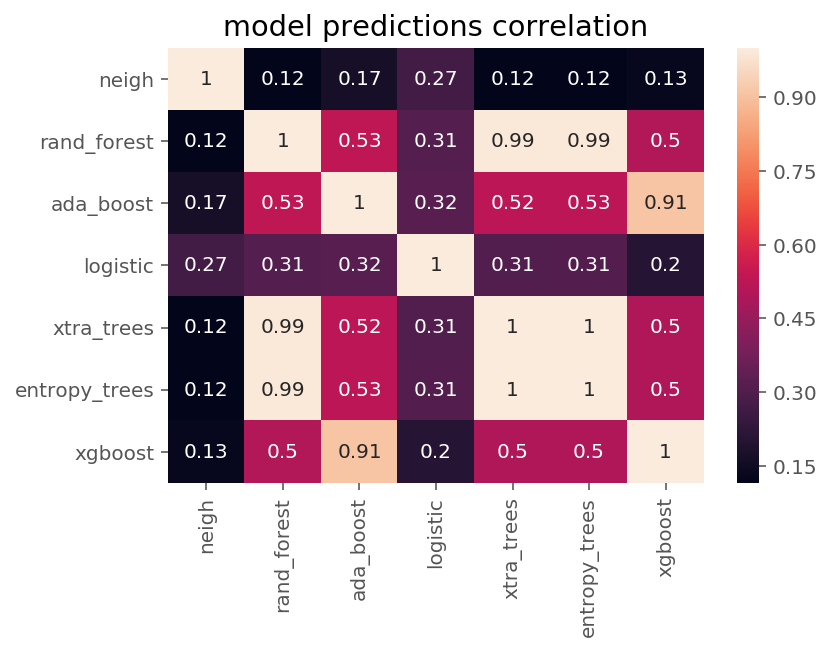

In [102]:
fig, ax = plt.subplots()
sns.heatmap(predictions_df.corr(), annot=True, ax=ax)
plt.title('model predictions correlation')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Explanation of stacking models-
There are some really good posts about this technique around but in essence Stacking models is a way of combining a load of different models (the more uncorrelated the better) and then use another model to create a second layer prediction based on the original data and also the other model predictions. The hope is that the second layer model will see where the first layer models did badly and where they did well, thus smoothing out the wrinkles in the models. One example is from space missions. During space missions its really important that all signals are correct otherwise you could die, so the simplest solution around making sure there was very little chance of error was repetition-code. In practice this meant relaying a signal multiple times in equal chuncks and then having a majority vote on which one was correct. This can be extrapolated to machine learning models. Say for instance if we had three models and they all had 0.8 accuracy if we used majority voting the ensemble would have an accuracy of 0.9- can argue that the model is more robust. However not much point if they all preidct the same thing which means uncorrelated predictions are important. 

process for stacked generalization -
split the training data
fit first stage model on first bit of training data and create predictions for other bit
do the reverse for the same model
do this for however many models you want
now train a second stage stacker model on predictions from first 

I have created a class that is basically an extension of an sk learn model that also does the above process as well.

Some of the inspiration for the first layer predict function can be found here-
https://github.com/emanuele/kaggle_pbr/blob/master/blend.py
and
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

also one of the MLWave ones is very cool but a bit more complex 
https://github.com/MLWave/Kaggle-Ensemble-Guide/blob/master/src/blend_proba.py

all of these were using depreciated functions and older code so here is a more up to date one
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/



In [9]:
kf = KFold(n_splits=5, random_state=1, shuffle=False)

In [67]:
class stacked_model():
    #passthrough means that the second layer model uses the training data as well as the first layer predictions
    #use probability means that the second layer model uses model.predict_proba() rather than predicting classes instead
    def __init__(self,
                 base_models,
                 second_layer_model,
                 use_probability=False,
                 allow_passthrough=False):
        self.base_models = base_models
        self.second_layer_model = second_layer_model
        self.use_probability = use_probability
        self.allow_passthrough = allow_passthrough
        self.first_layer_train_preds = None
        self.first_layer_test_preds = None

    #this function gets first level model predictions and stores them within the class object
    def first_layer_predict(self, X_train, X_test, y_train):
        '''get out of fold predictions from a model 
        for training set and test set'''

        #creating array to fit all the first layer models predictions in
        first_layer_training = np.zeros(
            (X_train.shape[0], len(self.base_models)))
        first_layer_test = np.zeros((X_test.shape[0], len(self.base_models)))

        #this is for if we want to use prediction probabilities or the predicted classes for second layer model
        if self.use_probability == False:

            for ind, clf in enumerate(self.base_models):
                #init what we are going to put our predictions into
                #predictions on training set
                oof_train = np.zeros((X_train.shape[0], ))
                #predictions on test set
                oof_test = np.zeros((X_test.shape[0], ))
                #aggregating the predictions
                oof_test_batch = np.empty((5, X_test.shape[0]))

                #now going to loop over folds in our dataset and fit a model on the training data
                #then we predict on the training set and the test set
                for i, (train_index, test_index) in enumerate(
                        kf.split(X_train, y_train.values)):

                    #because x is a numpy array and y is a pandas series have to do iloc on y but not on x
                    x_batch_train = X_train[train_index]
                    y_batch_train = y_train.iloc[train_index]
                    x_batch_test = X_train[test_index]

                    #here we are training the classifier
                    clf.fit(x_batch_train, y_batch_train)
                    #curious as to what scores my model is getting throughout
                    print(clf.score(X_train, y_train))

                    #here we are training the classifier
                    #storing predictions for the test batch of X_train (bit confusing terminology)
                    oof_train[test_index] = clf.predict(x_batch_test)
                    #storing predictions for X_test
                    oof_test_batch[i, :] = clf.predict(X_test)
                #aggregating the batches
                oof_test[:] = oof_test_batch.mean(axis=0)
                #reshaping so they are columns instead of rows -easier to put back into a dataframe
                first_layer_training[:,
                                     ind] = np.ravel(oof_train.reshape(-1, 1))
                first_layer_test[:, ind] = np.ravel(oof_test.reshape(-1, 1))

            #now putting all the predictions for the first layer into self so can use the second layer for predictions
            if self.allow_passthrough == False:

                self.first_layer_train_preds = first_layer_training
                self.first_layer_test_preds = first_layer_test
                return first_layer_training, first_layer_test

            else:

                first_layer_train_data = np.concatenate(
                    (X_train, first_layer_training), axis=1)
                first_layer_test_data = np.concatenate(
                    (X_test, first_layer_test), axis=1)
                self.first_layer_train_preds = first_layer_train_data
                self.first_layer_test_preds = first_layer_test_data
                return first_layer_train_data, first_layer_test_data

        else:

            for ind, clf in enumerate(self.base_models):
                #init what we are going to put our predictions into
                #predictions on training set
                oof_train = np.zeros((X_train.shape[0], ))
                #predictions on test set
                oof_test = np.zeros((X_test.shape[0], ))
                #aggregating the predictions
                oof_test_batch = np.empty((5, X_test.shape[0]))

                #now going to loop over folds in our dataset and fit a model on the training data
                #then we predict on the training set and the test set
                for i, (train_index, test_index) in enumerate(
                        kf.split(X_train, y_train.values)):

                    #because x is a numpy array and y is a pandas series have to do iloc on y but not on x
                    x_batch_train = X_train[train_index]
                    y_batch_train = y_train.iloc[train_index]
                    x_batch_test = X_train[test_index]

                    #here we are training the classifier
                    clf.fit(x_batch_train, y_batch_train)
                    #curious as to what scores my model is getting throughout
                    print(clf.score(X_train, y_train))

                    #here we are training the classifier
                    #storing predictions for the test batch of X_train (bit confusing terminology)
                    oof_train[test_index] = clf.predict_proba(x_batch_test)[:,
                                                                            0]
                    #storing predictions for X_test
                    oof_test_batch[i, :] = clf.predict_proba(X_test)[:, 0]
                #aggregating the batches
                oof_test[:] = oof_test_batch.mean(axis=0)
                #reshaping so they are columns instead of rows -easier to put back into a dataframe
                first_layer_training[:,
                                     ind] = np.ravel(oof_train.reshape(-1, 1))
                first_layer_test[:, ind] = np.ravel(oof_test.reshape(-1, 1))

            #now putting all the predictions for the first layer into self so can use the second layer for predictions
            if self.allow_passthrough == False:

                self.first_layer_train_preds = first_layer_training
                self.first_layer_test_preds = first_layer_test
                return first_layer_training, first_layer_test

            else:

                first_layer_train_data = np.concatenate(
                    (X_train, first_layer_training), axis=1)
                first_layer_test_data = np.concatenate(
                    (X_test, first_layer_test), axis=1)
                self.first_layer_train_preds = first_layer_train_data
                self.first_layer_test_preds = first_layer_test_data
                return first_layer_train_data, first_layer_test_data

    #fits second layer model onto X_train predictions
    def second_layer_fit(self, y_train):

        self.second_layer_model.fit(self.first_layer_train_preds, y_train)

    def get_first_layer_preds(self):
        return self.first_layer_train_preds

    #returns the cv scores and its mean for the model
    def cv_score(self, X_train, y_train, cv=5, shuffle=False):

        if X_train == None:
            cv_scores = cross_val_score(self.second_layer_model,
                                        self.first_layer_train_preds,
                                        y_train,
                                        cv=cv,
                                        shuffle=shuffle)
            return cv_scores, cv_scores.mean()
        else:
            cv_scores = cross_val_score(self.second_layer_model,
                                        X_train,
                                        y_train,
                                        cv=cv,
                                        shuffle=shuffle)
            return cv_scores, cv_scores.mean()

    #same as sklearn version basically
    def score(self, X, y):

        if X == 'train':
            return self.second_layer_model.score(self.first_layer_train_preds,
                                                 y)

        if X == 'test':
            return self.second_layer_model.score(self.first_layer_test_preds,
                                                 y)
        else:
            return self.second_layer_model.score(X, y)

    def predict(self, X='train'):

        if X == 'train':
            return self.second_layer_model.predict(
                self.first_layer_train_preds)

        if X == 'test':
            return self.second_layer_model.predict(self.first_layer_test_preds)

        else:
            return self.second_layer_model.predict(X)

    def predict_probs(self, X):
        return self.second_layer_model.predict_proba(X)

    def get_features(self):
        return self.second_layer_model.feature_importances_

In [24]:
neigh = KNeighborsClassifier(n_neighbors=140, n_jobs=3)

rf_ent = RandomForestClassifier(n_estimators=800,
                                random_state=1,
                                min_samples_leaf=2,
                                criterion='entropy')

rf = RandomForestClassifier(n_estimators=800,
                            random_state=1,
                            min_samples_leaf=2)

ad_model = AdaBoostClassifier(n_estimators=1000,
                              learning_rate=0.1,
                              random_state=1)

log_reg = LogisticRegression(C=4.281332398719396,
                             penalty='l2',
                             solver='saga',
                             max_iter=10000,
                             random_state=1)

xtra_trees = ExtraTreesClassifier(800, random_state=1)

xg_reg = xgb.XGBClassifier(objective='reg:logistic',
                           colsample_bytree=0.3,
                           learning_rate=0.01,
                           max_depth=2,
                           min_child_weight=4,
                           gamma=0.1,
                           n_estimators=800)

xg_test = xgb.XGBClassifier(learning_rate=0.08,
                            n_estimators=1500,
                            max_depth=3,
                            min_child_weight=1,
                            gamma=0.6,
                            subsample=0.4,
                            colsample_bytree=0.8,
                            objective='binary:logistic',
                            nthread=4,
                            scale_pos_weight=1,
                            reg_alpha=0.0001,
                            eval_metric='error')

In [68]:
model_list = [neigh, rf_ent, rf, ad_model, log_reg, xtra_trees, xg_reg]

#I included a print statement so could see that the function was still running
stacked_classifier = stacked_model(base_models=model_list,
                                   second_layer_model=xg_test,
                                   use_probability=False,
                                   allow_passthrough=True)
stacked_classifier.first_layer_predict(X_train, X_test, y_train)

0.6722092494789136
0.6715196915795577
0.6720838753153944
0.6712062561707596
0.6717547681361563
0.95469291165823
0.9521384130765252
0.9550690341487877
0.9544735068720713
0.9541600714632732
0.9516996035042079
0.949489883872181
0.951683931733768
0.9512764657023304
0.9506182513438544
0.795812502938457
0.7963296713629738
0.7960632512654955
0.795640113463618
0.7961729536585748
0.7131439138679496
0.7129401808522309
0.7133163033427886
0.7136297387515868
0.7141625789465436
0.9461674685389209
0.9441614819226128
0.9448823833628485
0.9451174599194471
0.945133131689887
0.7869892961807895
0.7870363114921093
0.7871616856556285
0.7869892961807895
0.7871930291965084


(array([[-1.70393885, -1.70393885, -1.70393885, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.59872543,  0.59872543,  0.59872543, ...,  0.        ,
          0.        ,  0.        ],
        [-0.70804067, -0.70804067, -0.70804067, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.4405112 ,  0.4405112 ,  0.4405112 , ...,  0.        ,
          0.        ,  0.        ],
        [-1.50849519, -1.50849519, -1.50849519, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.64171427,  1.64171427,  1.64171427, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.07603636,  0.07603636,  0.07603636, ...,  0.        ,
          0.        ,  0.        ],
        [-0.95535358, -0.95535358, -0.95535358, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.70952657,  1.70952657,  1.70952657, ...,  0.        ,
          1.        ,  1.        ],
        ...,
        [-1.47400257, -1.47400257, -1.47400257, ...,  

In [71]:
stacked_classifier.second_layer_fit(y_train)

In [72]:
stacked_classifier.score(X='train', y=y_train)

0.8308232381012083

In [73]:
stacked_classifier.score(X='test', y=y_test)

0.793016987400489

In [74]:
first_layer_predictions = stacked_classifier.get_first_layer_preds()

In [56]:
xg_test = xgb.XGBClassifier(learning_rate=0.08,
                            n_estimators=1500,
                            max_depth=3,
                            min_child_weight=1,
                            gamma=0.6,
                            subsample=0.4,
                            colsample_bytree=0.8,
                            objective='binary:logistic',
                            nthread=4,
                            scale_pos_weight=1,
                            reg_alpha=0.0001,
                            eval_metric='error')
xg_test.fit(first_layer_predictions, y_train)
xg_test.score(first_layer_predictions, y_train)

0.8308232381012083

In [75]:
#putting my data into a matrix to allow for cross validation
training_matrix = xgb.DMatrix(data=first_layer_predictions, label=y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [76]:
param_dict = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 27,
    'reg_alpha': 0.0001,
    'eval_metric': 'error',
}

In [77]:
cv_results = xgb.cv(dtrain=training_matrix,
                    params=param_dict,
                    nfold=5,
                    num_boost_round=1000,
                    early_stopping_rounds=200,
                    metrics="error",
                    as_pandas=True,
                    seed=123)

In [78]:
cv_results.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
31,0.194381,0.001046,0.201884,0.003177
32,0.194201,0.001096,0.201790,0.003023
33,0.194044,0.000991,0.201617,0.003242
34,0.193930,0.001015,0.201492,0.003425
35,0.193762,0.000992,0.201163,0.003368


In [83]:
#highlighting the first level model importances to the second level model
model_importances = pd.DataFrame({
    'models': [
        'rf_entropy', 'rf_normal', 'ada_boost', 'logistic_regression',
        'extra_trees', 'knn', 'xgboost'
    ],
    'model_importance as second level features':
    stacked_classifier.get_features()[-7:]
})

model_importances

,models,model_importance as second level features
0,rf_entropy,0.003117
1,rf_normal,0.019631
2,ada_boost,0.010465
3,logistic_regression,0.186486
4,extra_trees,0.024316
5,knn,0.008428
6,xgboost,0.151216


#### Stacking using probabilities

After trying to use purely class predictions from the first level models, I went on to use the class prediction probabilities from the first layer of models to see if it would improve the accuracy scores.

In [85]:
stacked_probability = stacked_model(base_models=model_list,
                                    second_layer_model=xg_test,
                                    use_probability=True,
                                    allow_passthrough=True)
stacked_probability.first_layer_predict(X_train, X_test, y_train)

0.6722092494789136
0.6715196915795577
0.6720838753153944
0.6712062561707596
0.6717547681361563
0.95469291165823
0.9521384130765252
0.9550690341487877
0.9544735068720713
0.9541600714632732
0.9516996035042079
0.949489883872181
0.951683931733768
0.9512764657023304
0.9506182513438544
0.795812502938457
0.7963296713629738
0.7960632512654955
0.795640113463618
0.7961729536585748
0.7131439138679496
0.7129401808522309
0.7133163033427886
0.7136297387515868
0.7141625789465436
0.9461674685389209
0.9441614819226128
0.9448823833628485
0.9451174599194471
0.945133131689887
0.7869892961807895
0.7870363114921093
0.7871616856556285
0.7869892961807895
0.7871930291965084


(array([[-1.70393885, -1.70393885, -1.70393885, ...,  0.89223372,
          0.8375    ,  0.93965614],
        [ 0.59872543,  0.59872543,  0.59872543, ...,  0.61760048,
          0.695     ,  0.73261505],
        [-0.70804067, -0.70804067, -0.70804067, ...,  0.80050709,
          0.72125   ,  0.95105255],
        ...,
        [ 0.4405112 ,  0.4405112 ,  0.4405112 , ...,  0.98661626,
          0.8675    ,  0.95575786],
        [-1.50849519, -1.50849519, -1.50849519, ...,  0.72750246,
          0.8075    ,  0.77973521],
        [ 1.64171427,  1.64171427,  1.64171427, ...,  0.85595424,
          0.7725    ,  0.96598852]]),
 array([[ 0.07603636,  0.07603636,  0.07603636, ...,  0.61355722,
          0.62125   ,  0.65520481],
        [-0.95535358, -0.95535358, -0.95535358, ...,  0.75745134,
          0.7805    ,  0.94485737],
        [ 1.70952657,  1.70952657,  1.70952657, ...,  0.63453987,
          0.46625   ,  0.20089084],
        ...,
        [-1.47400257, -1.47400257, -1.47400257, ...,  

In [86]:
stacked_probability.second_layer_fit(y_train)

In [87]:
stacked_probability.score(X='train', y=y_train)

0.8302277108244919

In [88]:
stacked_probability.score(X='test', y=y_test)

0.7943960383626903

In [89]:
first_layer_predictions_proba = stacked_probability.get_first_layer_preds()

In [112]:
#setting parameters for model
xg_prob = xgb.XGBClassifier(learning_rate=0.08,
                            n_estimators=1500,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0.6,
                            subsample=0.4,
                            colsample_bytree=0.8,
                            objective='binary:logistic',
                            nthread=4,
                            scale_pos_weight=1,
                            reg_alpha=0.0001,
                            eval_metric='error')

In [114]:
#fitting model
xg_prob.fit(data_and_probabilites_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='error',
              gamma=0.6, learning_rate=0.08, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1500, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.0001, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.4, verbosity=1)

In [90]:
#creating training matrix for xg boost cv
prob_training_matrix = xgb.DMatrix(data=first_layer_predictions_proba,
                                   label=y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [94]:
#running xgboost cross validation
cv_results_probs = xgb.cv(dtrain=prob_training_matrix,
                          params=param_dict,
                          nfold=5,
                          num_boost_round=1500,
                          early_stopping_rounds=200,
                          metrics="error",
                          as_pandas=True,
                          seed=123)

In [95]:
#getting xgboost cross validation scores
cv_results_probs.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
61,0.186843,0.000826,0.201915,0.002511
62,0.186553,0.000763,0.201946,0.002439
63,0.186467,0.000754,0.201900,0.002416
64,0.186200,0.000747,0.201774,0.002464
65,0.186040,0.000751,0.201664,0.002371


Overall it can be argued that using probabilities for the first level models turns out to have better results, with a better cv score and also a better test score.

## Evaluation of the Models

In this section of the project I am going to evaluate our models further using confusion matrices and ROC curves. Additionally I am going to change the threshold prediction probability needed to predict a bad loan so to incease the precision of the model. This is explained in more detail below.

### Stacked Model Evaluation

In [105]:
X_test_first_layer_preds = stacked_probability.first_layer_test_preds

In [107]:
X_all = np.concatenate(
    (first_layer_predictions_proba, X_test_first_layer_preds))

In [111]:
#getting the probabilities so we can plot the roc and precision recall curves
stacked_probabilities = stacked_probability.predict_probs(X_all)

In [113]:
Y_pp = pd.DataFrame(stacked_probabilities,
                    columns=['class_0_pp', 'class_1_pp'])

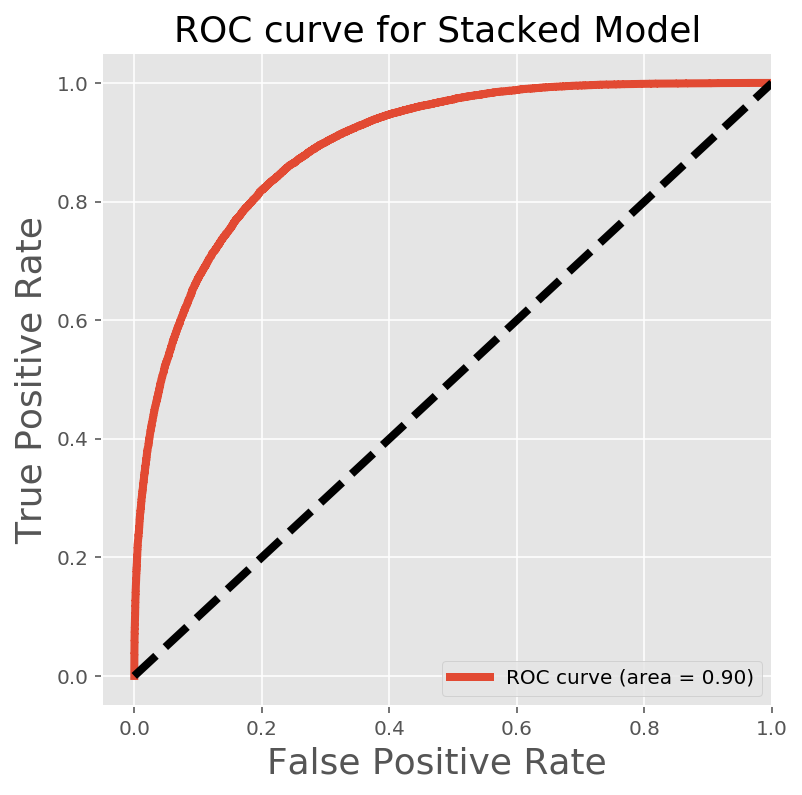

In [115]:
fpr, tpr, threshold = roc_curve(np.concatenate((y_train, y_test)),
                                Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve for Stacked Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

A ROC curve tells us about how good our model can classify loans and the trade off between recall and specificity when changing the prediciton probability threshold. True positive rate is calculated as the number of true positives over the number of true positives and false negatives. False positive rate on the other had is calculated as the number of false positives divided by the sum of false positives and true negatives. In this case the area under the curve is high which is a good indication that the model is worth something.

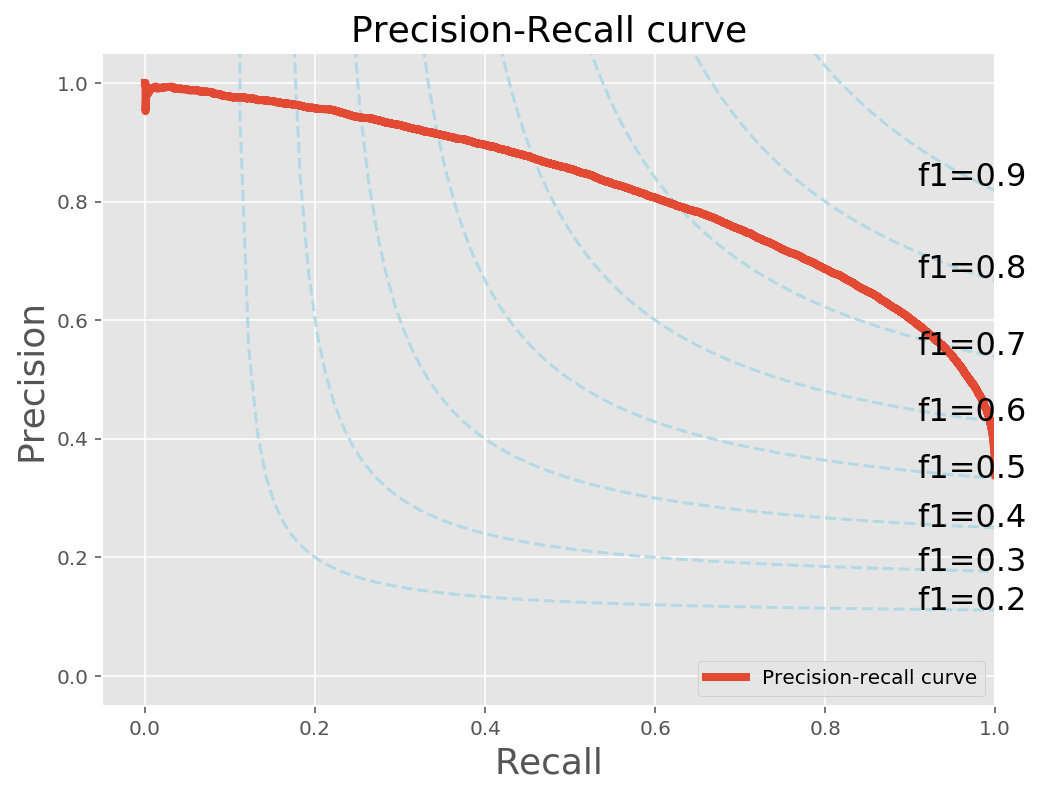

In [117]:
cmap = ListedColormap(sns.color_palette("husl", 3))


def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to 
        the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1. / (2. / const - 1. / x_vals)
        ax.plot(x_vals[y_vals > 0],
                y_vals[y_vals > 0],
                color='lightblue',
                ls='--',
                alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2] + 0.0),
                    fontsize=fontsize)

    return fig, ax


fig, ax = plot_f1_lines()

precision, recall, threshold = precision_recall_curve(
    np.concatenate((y_train, y_test)), Y_pp.class_1_pp)

ax.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Precision- Recall curve indicates the trade off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. Precision is the ratio of true positives divided by the sum of true positives and false positives. I have also plotted F1 lines onto the graph- the F1 score is the harmonic mean of precision and recall. It's harmonic because the precision and recall are ratios.

In [119]:
#getting the class predictions for the confusion matrix
stacked_predictions = stacked_probability.predict(X_all)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [124]:
#creating an initial confusion matrix
confusion1 = confusion_matrix(np.concatenate((y_train, y_test)),
                              stacked_predictions)
confusion_df = pd.DataFrame(confusion1,
                            index=['is_good', 'is_bad'],
                            columns=['predicted_good', 'predicted_bad'])
#giving labels for the confusion matrix
confusion_df

,predicted_good,predicted_bad
is_good,47744,5291
is_bad,8822,17905


In [123]:
print(
    classification_report(np.concatenate((y_train, y_test)),
                          stacked_predictions,
                          digits=4))

              precision    recall  f1-score   support

           0     0.8440    0.9002    0.8712     53035
           1     0.7719    0.6699    0.7173     26727

    accuracy                         0.8231     79762
   macro avg     0.8080    0.7851    0.7943     79762
weighted avg     0.8199    0.8231    0.8197     79762



We would like to minimise the amount of false positives in our predictions as it is probably more dangerous to think a loan will be ok for it to turn bad compared to preparing for the loan to go bad and then it does not. To do this we can decrease the threshold probability at which the model will consider the loan to have gone bad. 

In [126]:
def predict_at_threshold(x, threshold=0.5):
    """changes the prediction threshold at 
    which we predict a loan to be good or bad"""
    if x >= threshold:
        return 1
    else:
        return 0

In [127]:
Y_pp['predicted_class'] = Y_pp.class_1_pp.map(
    lambda x: predict_at_threshold(x, threshold=0.3))

In [129]:
confusion2 = confusion_matrix(np.concatenate((y_train, y_test)),
                              Y_pp.predicted_class.values)

confusion_lower_thresh = pd.DataFrame(
    confusion2,
    index=['is_good', 'is_bad'],
    columns=['predicted_good', 'predicted_bad'])
confusion_lower_thresh

,predicted_good,predicted_bad
is_good,40317,12718
is_bad,3813,22914


The amount that we lower the threshold by is dependent on our goals- we still want to have a good level of accuracy while decreasing the false negatives as much as possible.

In [130]:
print(
    classification_report(np.concatenate((y_train, y_test)),
                          Y_pp.predicted_class.values,
                          digits=4))

              precision    recall  f1-score   support

           0     0.9136    0.7602    0.8299     53035
           1     0.6431    0.8573    0.7349     26727

    accuracy                         0.7927     79762
   macro avg     0.7783    0.8088    0.7824     79762
weighted avg     0.8229    0.7927    0.7980     79762



### Evaluation of Simpler Unstacked XG Boost for comparison

In [146]:
full_x = np.concatenate((Xd_trains, Xd_tests))

In [152]:
Y_pp_orig = pd.DataFrame(xg_reg_pre_words.predict_proba(full_x),
                         columns=['class_0_pp', 'class_1_pp'])

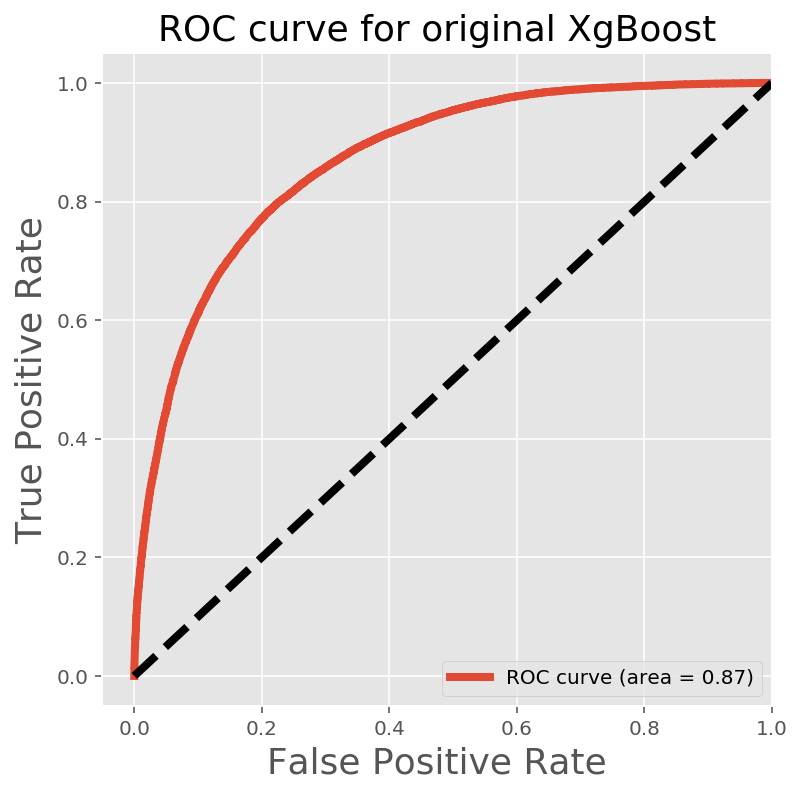

In [153]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(np.concatenate((yd_train, yd_test)),
                                Y_pp_orig.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve for original XgBoost', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Here we can see that the difference in ROC curves for the two models is quite small, however a small difference in the models predictive power when scaled up to suit business needs may mean a lot.

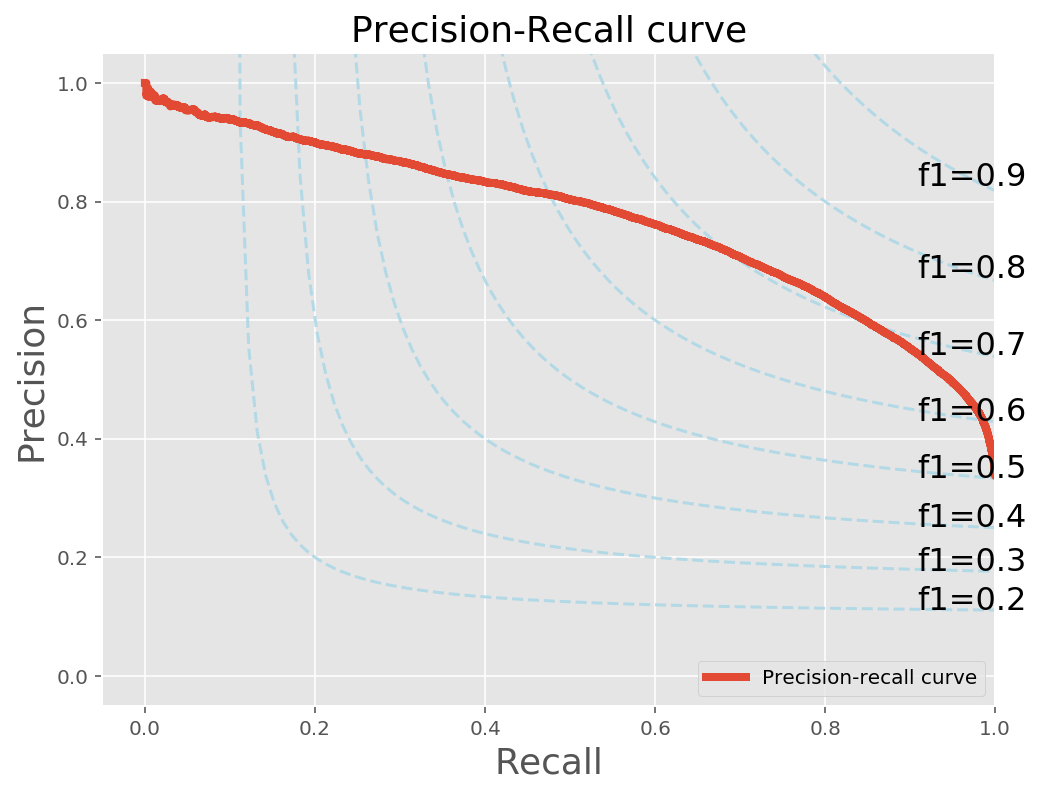

In [154]:
fig, ax = plot_f1_lines()

precision, recall, threshold = precision_recall_curve(
    np.concatenate((yd_train, yd_test)), Y_pp_orig.class_1_pp)

ax.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [156]:
orig_predictions = xg_reg_pre_words.predict(full_x)
orig_confusion = confusion_matrix(np.concatenate((yd_train, yd_test)),
                                  orig_predictions)

orig_confusion_df = pd.DataFrame(orig_confusion,
                                 index=['is_good', 'is_bad'],
                                 columns=['predicted_good', 'predicted_bad'])
orig_confusion_df

,predicted_good,predicted_bad
is_good,47710,5325
is_bad,10359,16368


In [157]:
print(
    classification_report(np.concatenate((yd_train, yd_test)),
                          orig_predictions,
                          digits=4))

              precision    recall  f1-score   support

           0     0.8216    0.8996    0.8588     53035
           1     0.7545    0.6124    0.6761     26727

    accuracy                         0.8034     79762
   macro avg     0.7881    0.7560    0.7675     79762
weighted avg     0.7991    0.8034    0.7976     79762



Overall it can be argued that on a large scale the difference in the two models would lead to a substantial increase in bad loan detection and therefore be worth the extra computational costs. Some important features common across all models made sense- those including late fees gathered throughout the loan, interest rate, and DTI. However it was suprising that credit inquiries into the loan had such a large effect- easily the largest impact feature.

In the future I would like to further this project by firstly increasing the scope of the data to include other years, and second try to obtain data on the full lifecyle of loans to gain a more concrete idea of the features available whilst a loan is still active as this part of the project proved difficult. I would also like to try different combinations of stacked models to see if they could provide better results and justify the extra complexity further. Using prediction probabilities has a lot of promise and I would want to further optimise the second level model that uses these. Finally although I tried using PCA to reduce model complexity,I did not have time to optimize hyperparameters for models using features processed by PCA, in the future I would like to do this as it may somewhat offset the increase in model complexity for a stacked model.

In [ ]:
#git remote remove origin
#git remote add origin new url